In [329]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

from pylab import rcParams
import sklearn 

In [330]:
pd.options.mode.chained_assignment = None  # default='warn'

In [331]:
df=pd.read_excel("rK3g26ERseWlQI7rj1yw_Table_1.xlsx")

In [332]:
max_value = df['Pow'].max()
min_value = df['Pow'].min()

In [333]:
#Insert the new column normalized power(%)

In [334]:
df.insert(6, "NPow", (df.Pow-min_value)/(max_value-min_value), True)

In [335]:
df.insert(7, "NPow(%)", 100*df.NPow, True)

In [336]:
df.head()

,Time_stamp,date_num,Ws,Pow,Temp,Pressure,NPow,NPow(%)
0,'2012-01-01 00:00:00',734869.000000,8.974833,1310.025024,6.57349,962.732971,0.576746,57.674591
1,'2012-01-01 00:10:00',734869.006944,9.908769,1684.520996,6.62630,962.578003,0.736421,73.642121
2,'2012-01-01 00:20:00',734869.013889,9.639434,1532.052002,6.81988,962.244019,0.671412,67.141241
3,'2012-01-01 00:30:00',734869.020833,11.836330,1997.869995,6.93197,961.859985,0.870025,87.002503
4,'2012-01-01 00:40:00',734869.027778,11.687170,2135.758057,6.98667,961.864014,0.928817,92.881690


# Data Pre-processing

In [337]:
#Data points where maximum wind speed has reached more than 25 m/s are also filtered out


In [338]:
if df['Ws'].max()>25:
    df=df[df['Ws']<=25]

In [339]:
#samples with missing values or no power production are filtered out

In [340]:
df1=df.dropna()

In [341]:
#a lower limit of output power is set at 0 kW for data sample selection.
df2= df1[df1['Pow'] >= 10]  


In [342]:

#cluster filter is applied on the training data and aims to remove outliers depending on the operating conditions 
#of the wind turbine.
#A multivariate outlier detection approach based on Mahalanobis distance is used in 

In [343]:
#Time_stamp column not used
df3=df2[['date_num', 'Ws', 'Pow', 'Temp', 'Pressure', 'NPow',
       'NPow(%)']]



In [344]:
df3.columns

Index(['date_num', 'Ws', 'Pow', 'Temp', 'Pressure', 'NPow', 'NPow(%)'], dtype='object')

In [345]:
df3.shape

(3898, 7)

In [346]:
#Find clusters

import numpy as np
from scipy.cluster import hierarchy 
from scipy.spatial import distance

X = df3.iloc[:, [1,3]].values
#Ws and Temperature ranges

row_clusters=linkage(pdist(X,metric='euclidean'),method='ward')
print(row_clusters.shape)

#y = distance.pdist(X, metric="euclidean")
#y[np.isnan(y)] = 1

#out = hierarchy.linkage(y,method='ward')

#children = out[:, :2].astype(np.int)
#row_clusters=linkage(pdist(children,metric='euclidean'),method='ward')
#print(children.shape)

(3897, 4)


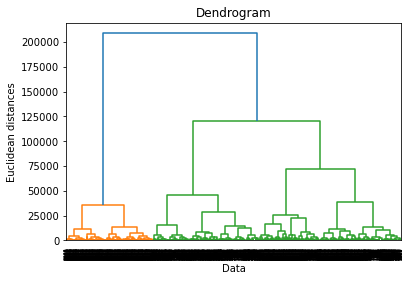

In [347]:
#Show dendrogram to see how many clusters
import scipy.cluster.hierarchy as sch

children=row_clusters

try:
    dendrogram = sch.dendrogram(sch.linkage(children, method  = "ward"))
    plt.title('Dendrogram')
    plt.xlabel('Data')
    plt.ylabel('Euclidean distances')
    plt.show()
except:
  print("An exception occurred")
    

In [349]:
a=len(dendrogram)

In [425]:
#max num 3
N_clusters=3
count=0

In [426]:
if a>0:
    exists=True
else:
    exists=False

In [427]:
from sklearn.cluster import AgglomerativeClustering 

hc = AgglomerativeClustering(n_clusters =N_clusters, affinity = 'euclidean', linkage ='ward')

In [428]:
y_hc=hc.fit_predict(children)

Text(0, 0.5, 'Temp')

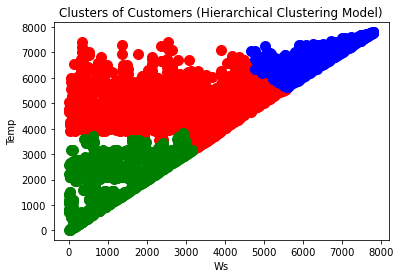

In [429]:
X=children
plt.scatter(X[y_hc==0, 0], X[y_hc==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X[y_hc==1, 0], X[y_hc==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(X[y_hc==2, 0], X[y_hc==2, 1], s=100, c='green', label ='Cluster 3')


plt.title('Clusters of Customers (Hierarchical Clustering Model)')
plt.xlabel('Ws')
plt.ylabel('Temp')
#plt.show()

In [430]:
def is_pos_def(A):
    '''define if the matrix is positive definite'''
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False


def MahalanobisDist(data,verbose=False):
    '''calculates Mahalanobis distance from the mean value'''
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            vars_mean = []
            for i in range(data.shape[0]):
                vars_mean.append(list(data.mean(axis=0)))
            
            diff = data - vars_mean
            md = []
            for i in range(len(diff)):
                md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))

            if verbose:
                print("Covariance Matrix:\n {}\n".format(covariance_matrix))
                print("Inverse of Covariance Matrix:\n {}\n".format(inv_covariance_matrix))
                print("Variables Mean Vector:\n {}\n".format(vars_mean))
                print("Variables - Variables Mean Vector:\n {}\n".format(diff))
                print("Mahalanobis Distance:\n {}\n".format(md))
            return md
        else:
            print("2 Error: Inverse of Covariance Matrix is not positive definite!")
            return md
    else:
        print("1 Error: Covariance Matrix is not positive definite!")
        return md

In [431]:
def cluster(count,df3):
    ''' Find the cluster interval of Ws and Temp'''
        print('Cluster'+str(count+1))
        a=[]
        b=[]
        a=X[y_hc==count, 0]
        b=X[y_hc==count, 1]

        df4= pd.DataFrame({'Ws': a, 'Temp':b})
        df1_c1=df3[(df3['Ws']>=df4['Ws'].min())]
        df1_c2=df3[(df3['Ws']<=df4['Ws'].max())]
        df1_c=pd.concat([df1_c1,df1_c2])
        return df1_c

In [432]:
def insertColumns(result,data,pos):
    ''' Insert inside the dataframe the distance calculated and the probability density'''
            data.insert(pos, "dist", result, True)
            num_tot=data['date_num'].sum()
            data.insert(pos+1,'Pd(%)',((data['dist']*data['date_num']*100)/num_tot), True)
            return data

In [433]:
df3.shape

(3898, 7)

In [434]:
count=0

In [435]:
pd_list=[]

In [436]:
#Gives the list of dataframe for each cluster, in this case for T>=0

while count<N_clusters and exists:
    try:
        df4=cluster(count,df3)
        if df4.shape[0]>0:
            data=df4[(df3['Temp']>=0)]
            data1=data[['Ws','Temp']]

            list_df=data1.to_numpy()

            result=MahalanobisDist(list_df,verbose=False)
            if len(result)>0:
                pos=list_df.shape[1]
                data=insertColumns(result,data,pos)
                print(data.shape[0])
                pd_list.append(data)
                count=count+1
        else:
            count=count+1
            print(df4.shape[0])
            
    except:
        print('error')
        break

Cluster1


<ipython-input-436-70ba8e72c47e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=df4[(df3['Temp']>=0)]


5098
Cluster2
3645
Cluster3
7290


In [437]:
print(len(pd_list))

3


In [438]:
#Gives the list of dataframe for each cluster, in this case for T<0
count=0
pd_list_l=[]
while count<N_clusters and exists:
    try:
        df4=cluster(count,df3)
        if df4.shape[0]>0:
            data=df4[(df3['Temp']<0)]
            data1=data[['Ws','Temp']]

            list_df=data1.to_numpy()

            result=MahalanobisDist(list_df,verbose=False)
            if len(result)>0:
                pos=list_df.shape[1]
                data=insertColumns(result,data,pos)
                print(data.shape[0])
                pd_list_l.append(data)
                count=count+1
        else:
            count=count+1
            print(df4.shape[0])
            
    except:
        print('error')
        count=count+1

Cluster1
253
Cluster2
253
Cluster3
506


<ipython-input-438-c4106df96bc6>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=df4[(df3['Temp']<0)]


In [606]:
min_threshold=0.025

In [ ]:
#concatenate each resulting dataframe

In [607]:

df_end=pd.concat(pd_list)
print(df_end.shape[0])

16033


In [608]:
if df_end.shape[0]>0:
    df_end1=df_end[df_end['Pd(%)']>min_threshold]

In [ ]:
#plot for T>0

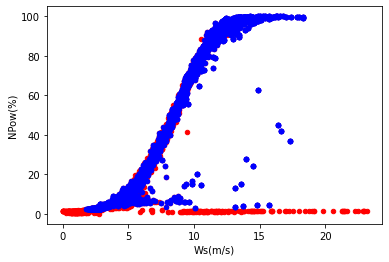

In [609]:
ax=df.plot(kind='scatter',x='Ws',y='NPow(%)',color='red')
df_end1.plot(ax=ax, kind='scatter',x='Ws',y='NPow(%)',color='blue')
ax.set_xlabel("Ws(m/s)")
ax.set_ylabel("NPow(%)")


plt.show()

In [629]:
#total data

In [630]:
df_end_tot=pd.concat([df_end,df_end2])

In [633]:
print(df_end2.shape[0])

1012


In [ ]:
#Figure 1 of the paper

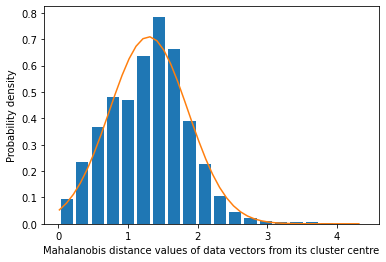

In [654]:
from scipy.stats import norm
plt.hist(df_end_tot.dist,bins=20,rwidth=0.8, density=True)
plt.xlabel('Mahalanobis distance values of data vectors from its cluster centre')
plt.ylabel('Probability density')
rng=np.arange(df_end_tot.dist.min(),df_end_tot.dist.max(),0.1)
plt.plot(rng,norm.pdf(rng,df_end_tot.dist.mean(),df_end_tot.dist.std()))

In [632]:
df_end2=pd.concat(pd_list_l)
print(df_end2.shape[0])

In [611]:
if df_end2.shape[0]>0:
    df_end2=df_end2[df_end2['Pd(%)']>min_threshold]

In [ ]:
#Concatenate all the dataframes with T>0 and T<0 

In [612]:
df_end3=pd.concat([df_end1,df_end2])

In [ ]:
#Final plot

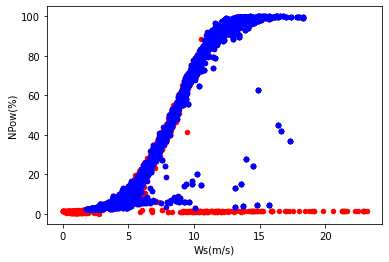

In [613]:
ax=df.plot(kind='scatter',x='Ws',y='NPow(%)',color='red')
df_end3.plot(ax=ax, kind='scatter',x='Ws',y='NPow(%)',color='blue')
ax.set_xlabel("Ws(m/s)")
ax.set_ylabel("NPow(%)")


plt.show()

In [627]:
df_end3.head()

,date_num,Ws,dist,Pd(%),Pow,Temp,Pressure,NPow,NPow(%)
3,734869.020833,11.83633,1.336502,0.026216,1997.869995,6.93197,961.859985,0.870025,87.002503
4,734869.027778,11.68717,1.328828,0.026065,2135.758057,6.98667,961.864014,0.928817,92.881690
5,734869.034722,12.14433,1.350488,0.026490,2149.540039,6.74057,961.499023,0.934693,93.469318
6,734869.041667,13.42517,1.745956,0.034247,2056.350098,5.35465,962.164978,0.894959,89.495942
118,734869.819444,10.85083,1.293719,0.025377,1946.447021,3.46283,958.982971,0.848100,84.809962


In [615]:
df_end3.shape[0]

7594

In [616]:
#outliers removal 

In [617]:
df_end4=df_end3[(df_end3['NPow(%)']<27)&(df_end3['Ws']>7)]

In [618]:
df_end4.describe()

,date_num,Ws,dist,Pd(%),Pow,Temp,Pressure,NPow,NPow(%)
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,734881.649177,10.638309,1.824956,0.037105,214.838359,3.461935,967.428376,0.109787,10.978692
std,10.257907,2.591474,0.391070,0.010399,164.709969,2.694065,9.718162,0.070228,7.022803
min,734870.381944,7.040812,0.972044,0.025134,29.454849,0.668453,944.645996,0.030744,3.074423
25%,734870.451389,8.643355,1.525131,0.029334,94.461464,1.657750,962.400970,0.058461,5.846136
50%,734887.694444,9.848253,1.832529,0.034632,117.016800,2.019645,964.231995,0.068078,6.807836
75%,734893.057292,13.156170,2.080734,0.041069,312.033203,6.051832,976.812988,0.151228,15.122826
max,734897.819444,15.714570,2.741468,0.075208,587.794983,7.930050,995.252991,0.268806,26.880588


In [619]:
con1=(df_end3['NPow(%)']<27)&(df_end3['Ws']>7)

In [620]:
df_end5=df_end3[~(con1)]

In [621]:
con2=(df_end3['NPow(%)']>20)&(df_end3['NPow(%)']<80)&(df_end3['Ws']>11)

In [622]:
df_end6=df_end3[~(con2)]

In [623]:
con3=(df_end6['NPow(%)']<27)&(df_end6['Ws']>7)

In [624]:
df_end7=df_end6[~(con3)]

In [625]:
df_end.shape[0]

16033

In [ ]:
#Ws vs Normalized Power

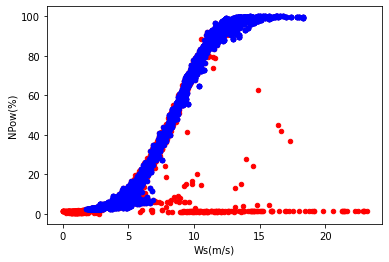

In [626]:
ax=df.plot(kind='scatter',x='Ws',y='NPow(%)',color='red')
df_end7.plot(ax=ax, kind='scatter',x='Ws',y='NPow(%)',color='blue')
ax.set_xlabel("Ws(m/s)")
ax.set_ylabel("NPow(%)")


plt.show()

In [ ]:
#Ws vs Power

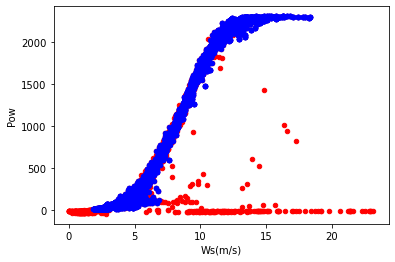

In [628]:
ax=df.plot(kind='scatter',x='Ws',y='Pow',color='red')
df_end7.plot(ax=ax, kind='scatter',x='Ws',y='Pow',color='blue')
ax.set_xlabel("Ws(m/s)")
ax.set_ylabel("Pow")


plt.show()